# Chapter 8.2: Baseball II (Optimization)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap08 import *

import pandas as pd
import numpy as np


In the previous chapter we developed a model of the flight of a
baseball, including gravity and a simple version of drag, but neglecting spin, Magnus force, and the dependence of the coefficient of drag on velocity.

In this chapter we apply that model to an optimization problem. In general, *optimization* is a process for improving a design by searching for the parameters that maximize a benefit or minimize a cost. For example, in this chapter we'll find the angle you should hit a baseball to maximize the distance it travels. And we'll use a new function, called `maximize_scalar` that searches for this angle efficiently.

## The Manny Ramirez Problem

Manny Ramirez is a former member of the Boston Red Sox (an American
baseball team) who was notorious for his relaxed attitude and taste for practical jokes. Our objective in this chapter is to solve the following Manny-inspired problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Fenway Park is a baseball stadium in Boston, Massachusetts. One of its
most famous features is the "Green Monster", which is a wall in left
field that is unusually close to home plate, only 310 feet away. To
compensate for the short distance, the wall is unusually high, at 37
feet (see <http://modsimpy.com/wally>).

Starting with `params` from the previous chapter, I'll make a new `Params` object with two additional parameters, `wall_distance` and `wall_height`, in meters.

In [2]:
# Convert feet to meters
feet_to_meter = 0.3048
params = dict(
    x = 0,          # m
    y = 1,          # m
    angle = 45,     # degree
    speed = 40,  # m / s

    mass = 145e-3,    # kg 
    diameter = 73e-3, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10,    # s
    
    wall_distance= 310*feet_to_meter,     # m
    wall_height= 37 * feet_to_meter)      # m

We'll need to adjust the `make_system` function:

In [3]:
def make_system(params):
    
    x, y, angle, speed, mass, diameter, C_d, rho, g, t_end, wall_distance, wall_height = params.values()
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, speed)
    
    # make the initial state
    init = pd.Series(dict(x=x, y=y, vx=vx, vy=vy))
    
    # compute the frontal area
    area = np.pi * (diameter/2)**2

    return dict(C_d=C_d, rho=rho, g=g, t_end=t_end,
                  mass=mass,wall_distance=wall_distance,
                  wall_height=wall_height,init = init,
                  area = area)

The answer we want is the minimum speed at which a ball can leave home plate and still go over the Green Monster. We'll proceed in the
following steps:

1.  For a given speed, we'll find the optimal *launch angle*, that is, the angle the ball should leave home plate to maximize its height when it reaches the wall.

2.  Then we'll find the minimum speed that clears the wall, given
    that it has the optimal launch angle.

## Finding the Range

Suppose we want to find the launch angle that maximizes *range*, that is, the distance the ball travels in the air before landing. We'll use a function in the ModSim library, `maximize_scalar`, which takes a function and finds its maximum.

The function we pass to `maximize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [11]:
def range_func(angle, params):
    params_var = params.copy()
    params_var.update(angle=angle)
    system = make_system(params_var)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    return x_dist

`range_func` makes a new `system` object with the given value of
`angle`. Then it calls `run_solve_ivp` and
returns the final value of `x` from the results.

In short, it tells us how far a ball will travel at the angle and speed given by the parameters.

We can call `range_func` directly like this:

In [12]:
range_func(45, params)

99.31829628352213

With launch angle 45°, the ball lands about 99 meters from home plate.

Now we can sweep a sequence of angles like this:

In [14]:
angles = linspace(20, 80, 21)
sweep = pd.Series([],dtype=np.float64)

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

Here's what the results look like.

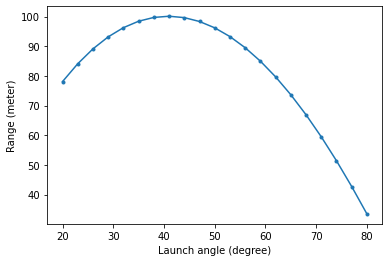

In [16]:
sweep.plot(xlabel='Launch angle (degree)',
         ylabel='Range (meter)',marker='.');

The dots represent actual data points determined by `range_func`.

It looks like the range is maximized when the initial angle is near 40°.

To find the optimal angle more precisely and more efficiently, we can use an ModSimPy algorithm called `maximize_scalar`.  Notice that range function has two arguments: `angle` and `params`.  `Maximize_scalar` is called here maximize the value of `range_func` over a range of possible values for the first argument `angle`.  `params` is included because this is necessary to run `range_func`, and `bounds` tells the function to test values for angle from 0 to 90.

In [17]:
res = maximize_scalar(range_func, params, bounds=[0, 90])

* The first parameter is `range_func`, the function we want to maximize.  This is maximized by adjusting the first parameter in that function (that is, `angle` is the first parameter in `range_func`). 

* The final parameter is the range of values we want to search; in this case, it's the range of angles from 0° to 90°. 

The return value from `maximize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the range when the ball is launched at the optimal angle.

In [20]:
res

     fun: 100.12417043314979
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 40.879287138759004

In [21]:
res.x, res.fun

(40.879287138759004, 100.12417043314979)

For these parameters, the optimal angle is about 41°, which yields a range of 100 m.
Now we have what we need to finish the problem; the last step is to find the minimum velocity needed to get the ball over the wall. In the exercises at the end of the chapter, I provide some suggestions. Then it's up to you!

## Summary

This chapter introduces an new tool, `maximize_scalar`, that provides an efficient way to search for the maximum of a function. We used it to find the launch angle that maximizes the distance a baseball flies through the air, given its initial velocity.

If you enjoy this example, you might be interested in this paper: "How to hit home runs: Optimum baseball bat swing parameters for maximum range trajectories", by Sawicki, Hubbard, and Stronge, at <http://modsimpy.com/runs>.

In the next chapter, we start a new topic: rotation!

### Exercise 1

Let's finish off the Manny Ramirez problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range; we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write an `event_func` that stops the simulation when the ball reaches the wall at `wall_distance`, which is a parameter in `params`.
Test your function with the initial conditions.

In [22]:
# Define the event_func

def event_func(t,state,system):
    x,y,vx,vy = state
    return x - system['wall_distance']

In [32]:
# Test event function
system = make_system(params)
event_func(0,system['init'],system)

-94.488

Next, write a function called `height_func` that takes a launch angle, simulates the flight of a baseball, and returns the height of the baseball when it reaches the wall.
Test your function with the initial conditions.

In [33]:
# Define height function
def height_func(angle,params):
    params_var = params.copy()
    params_var.update(angle=angle)
    system = make_system(params_var)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    height_at_wall = results.iloc[-1].y
    return height_at_wall

In [34]:
# Test height_function
height_func(45,params)

6.968278259866793

We know the ball that leaves the bat at 45 degrees travels about 99 meters, so it makes sense that it would be about 7 m above the ground when it passed the 94.5 m mark (that is, the location of the wall).

We now have a function that will tell us the height of the ball when it reaches the wall.  If we use this function in `maximize_scalar`, we can find the angle that will maximize this height.  Is it higher or lower than the angle that maximizes range?

In [35]:
# Find the optimal angle
params['speed'] = 40
max_ang = maximize_scalar(height_func,params,bounds=[0,90])
print(max_ang.x, max_ang.fun)

43.105080979218556 7.217049532932855


The angle that maximizes the height at the wall is a little higher than the angle that maximizes range.

We have maximized the height for a ball that has an initial velocity of 40 m/s.  Now, let's find the lowest speed that makes the height at the wall exactly 37 feet.  Essentially, we need to sweep through two parameters, angle and speed, to find the combination that will get us the lowest speed.

We have the tool to optimize the angle for a given speed.  Now we will use `root scalar` and an error function to find the lowest speed whose maximum height clears the wall.

Write an error function that takes a speed and a `system` object as parameters.  It should use `maximize_scalar` to find the angle that will produce the highest possible height of the ball at the wall, for the given speed.  Then it should return the difference between that optimal height and `wall_height`, which is a parameter in `params`.

This is the error function that we will try to set to zero with `root scalar`.

In [40]:
# Define the error function

def error_func(speed,params):
    params_var = params.copy()
    params_var.update(speed=speed)
    
    # For a given speed, find the angle that gives the maximum height at the wall
    max_ang = maximize_scalar(height_func,params_var,bounds=[0,90])
    print("Speed",speed,"Angle", max_ang.x, "Height", max_ang.fun)
    
    # Return the difference between the top of the wall and the optimal height
    # of the ball at the wall: this is what root_scalar will try to make zero
    return max_ang.fun - system['wall_height']

In [41]:
# Test function
error_func(40,params)

Speed 40 Angle 43.105080979218556 Height 7.217049532932855


-4.060550467067147

Then use `root_scalar` to find the answer to the problem, the minimum speed that gets the ball out of the park.

In [42]:
# Call root_scalar to find the angle and minimum speed to clear wall
res = root_scalar(error_func,params,bracket=[10,50])
res


Speed 10 Angle 86.72124468572068 Height -247.91663975523943
Speed 10.0 Angle 86.72124468572068 Height -247.91663975523943
Speed 50.0 Angle 52.22315471733168 Height 41.507789540329604
Speed 45.82202654918841 Angle 48.870201446357036 Height 28.308542158265958
Speed 40.763578911688 Angle 43.940206882010685 Height 10.21581411345618
Speed 41.06043786496562 Angle 44.25822094692066 Height 11.359681294555774
Speed 41.03913594496292 Angle 44.23552443791914 Height 11.277995193258526
Speed 41.037083988164675 Angle 44.23333713788136 Height 11.270123393937599


      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 41.03913594496292

And just to check, run `error_func` with the value you found.

In [39]:
# Check with error_function
error_func(41.0391,params)

Speed 41.0391 Angle 44.235486121894446 Height 11.277857304580827


0.0002573045808258456